In [356]:
from collections import defaultdict, namedtuple, Counter
import sys
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats


In [357]:
#phase_dir = '../phased_ancestry_quads'
#build = '37'
#phenotype = ''

phase_dir = '../phased_spark_quads'
build = '38'
phenotype = ''

chroms = [str(x) for x in range(1, 23)]
interval = 10000000


In [358]:
cyto = []
with open('../data/cytoBand%s.txt' % build, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0].startswith('chr') and pieces[0][3:] in chroms:
            cyto.append((pieces[0][3:], int(pieces[1]), int(pieces[2]), pieces[3], pieces[4]))

chrom_to_start_pos = [1]
for chrom in chroms[:-1]:
    chrom_length = max([x[2] for x in cyto if x[0]==chrom])
    chrom_to_start_pos.append(chrom_to_start_pos[-1] + chrom_length)
    

In [359]:
all_chroms, all_regions = [], []
FF_mat_pvalues, FF_pat_pvalues, FF_combined_pvalues = [], [], []
MF_mat_pvalues, MF_pat_pvalues, MF_combined_pvalues = [], [], []
MM_mat_pvalues, MM_pat_pvalues, MM_combined_pvalues = [], [], []
all_mat_pvalues, all_pat_pvalues, all_combined_pvalues = [], [], []
for i, chrom in enumerate(chroms):
    regions = np.load('%s/chr.%s.IST.pvalues.be.%sintervals.%d.regions.npy' % (phase_dir, chrom, phenotype, interval))
    all_chroms.append(i*np.ones((regions.shape[0],), dtype=int))
    all_regions.append(regions)
    p = np.load('%s/chr.%s.IST.pvalues.be.%sintervals.%d.npy' % (phase_dir, chrom, phenotype, interval))

    FF_mat_pvalues.append(p[:, 0, 0, :])
    FF_pat_pvalues.append(p[:, 0, 1, :])
    FF_combined_pvalues.append(p[:, 0, 2, :])
    MF_mat_pvalues.append(p[:, 1, 0, :])
    MF_pat_pvalues.append(p[:, 1, 1, :])
    MF_combined_pvalues.append(p[:, 1, 2, :])
    MM_mat_pvalues.append(p[:, 2, 0, :])
    MM_pat_pvalues.append(p[:, 2, 1, :])
    MM_combined_pvalues.append(p[:, 2, 2, :])
    all_mat_pvalues.append(p[:, 3, 0, :])
    all_pat_pvalues.append(p[:, 3, 1, :])
    all_combined_pvalues.append(p[:, 3, 2, :])
all_chroms = np.hstack(all_chroms)
all_regions = np.vstack(all_regions)

FF_mat_pvalues = np.vstack(FF_mat_pvalues)
FF_pat_pvalues = np.vstack(FF_pat_pvalues)
FF_combined_pvalues = np.vstack(FF_combined_pvalues)
MF_mat_pvalues = np.vstack(MF_mat_pvalues)
MF_pat_pvalues = np.vstack(MF_pat_pvalues)
MF_combined_pvalues = np.vstack(MF_combined_pvalues)
MM_mat_pvalues = np.vstack(MM_mat_pvalues)
MM_pat_pvalues = np.vstack(MM_pat_pvalues)
MM_combined_pvalues = np.vstack(MM_combined_pvalues)
all_mat_pvalues = np.vstack(all_mat_pvalues)
all_pat_pvalues = np.vstack(all_pat_pvalues)
all_combined_pvalues = np.vstack(all_combined_pvalues)

print(all_regions.shape, all_combined_pvalues.shape)


(278, 2) (278, 6)


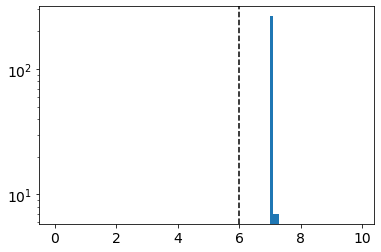

In [360]:
cutoff = 1000000
plt.hist(np.log10(all_regions[:, 1]-all_regions[:, 0]), 
         log=True, bins=np.arange(0, 10, 0.1))
plt.axvline(np.log10(cutoff), color='black', linestyle='--')
plt.show()

In [361]:
#include_in_display = np.zeros(all_positions.shape, dtype=bool)
#include_in_display[0] = True
#last_pos = all_positions[0]
#for i, pos in enumerate(all_positions):
#    if np.abs(pos - last_pos) > cutoff:
#        include_in_display[i] = True
#        last_ps = pos

include_in_display = np.ones((all_regions.shape[0]), dtype=bool)
#for c in cyto:
#    if c[0] in chroms and c[-1] == 'acen':
#        include_in_display[(all_chroms==chroms.index(c[0])) & (np.minimum(all_regions[:, 1], c[2])-np.maximum(all_regions[:, 0], c[1])>0)]=False
print('including', np.sum(include_in_display)/include_in_display.shape[0])



including 1.0


In [362]:
bonferonni_cutoff = -np.log10(0.05/(4*np.sum(include_in_display)))
print(bonferonni_cutoff)

4.34713478291002


IndexError: index 6 is out of bounds for axis 1 with size 6

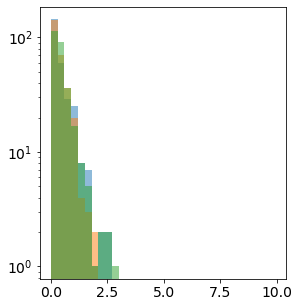

In [363]:
binsize = 0.3
x_chrom = -1 if 'X' not in chroms else chroms.index('X')
n = np.sum(include_in_display & (all_chroms != x_chrom))

def plot_pvalue_dist(pvalues):
    plt.hist(np.clip(-np.log10(pvalues[include_in_display & (all_chroms != x_chrom), 0]), None, 9), 
                     log=True, bins=np.arange(0, 10, binsize), alpha=0.5, label='UU')
    plt.hist(np.clip(-np.log10(pvalues[include_in_display & (all_chroms != x_chrom), 1]), None, 9), 
                     log=True, bins=np.arange(0, 10, binsize), alpha=0.5, label='AU')
    plt.hist(np.clip(-np.log10(pvalues[include_in_display & (all_chroms != x_chrom), 2]), None, 9), 
                     log=True, bins=np.arange(0, 10, binsize), alpha=0.5, label='AA')
    plt.hist(np.clip(-np.log10(pvalues[include_in_display & (all_chroms != x_chrom), 6]), None, 9), 
                     log=True, bins=np.arange(0, 10, binsize), alpha=0.5, label='UU+AA')
    plt.plot([binsize/2, np.log10(n*(1-(10**-binsize))) + binsize/2], 
             [n*(1-(10**-binsize)), 1], color='black', linestyle='--')  
    plt.axvline(bonferonni_cutoff, color='black', linestyle='--')
    plt.legend()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_pvalue_dist(all_mat_pvalues)
plt.title('all mat')#

plt.subplot(1, 3, 2)
plot_pvalue_dist(all_pat_pvalues)
plt.title('all pat')

plt.subplot(1, 3, 3)
plot_pvalue_dist(all_combined_pvalues)
plt.title('all combined')

plt.tight_layout()
plt.show()

In [354]:
xs = np.array([p+chrom_to_start_pos[c] for p, c in zip(all_regions[:, 0], all_chroms)])


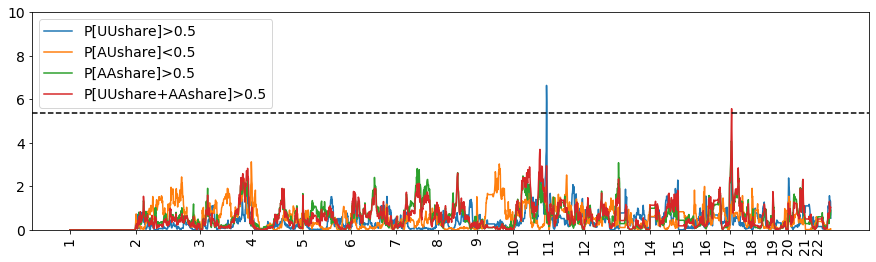

In [355]:
import matplotlib
plt.figure(figsize=(15, 4))
matplotlib.rcParams.update({'font.size': 14})

labels = ['P[UUshare]>0.5', 'P[AUshare]<0.5', 'P[AAshare]>0.5', 
          'P[AAshare]>P[AUshare]', 'P[UUshare]>P[AUshare]', 'P[UUshare+AAshare]>P[AUshare]',
         'P[UUshare+AAshare]>0.5']

for index in [0, 1, 2, 6]:
    #ax = plt.subplot(3, 1, index+1)
    plt.plot(xs[include_in_display], -np.log10(all_combined_pvalues[include_in_display, index]), label=labels[index])
    #plt.plot(xs[include_in_display], -np.log10(all_mat_pvalues[include_in_display, index]), label=labels[index] + ' mat')
    #plt.plot(xs[include_in_display], -np.log10(all_pat_pvalues[include_in_display, index]), label=labels[index] + ' pat')
    #plt.title(labels[index])
    plt.ylim([0, 10])

plt.xticks(chrom_to_start_pos, chroms, rotation=90)
plt.axhline(bonferonni_cutoff, color='black', linestyle='--')
plt.legend(loc='upper left')
#plt.tight_layout()
plt.show()

In [344]:
#print('simplex combined')
#indices = -np.log10(simplex_combined_pvalues)>bonferonni_cutoff
#start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0], np.where(indices[:-1] & ~indices[1:])[0]+1
#for start_index, end_index in zip(start_indices, end_indices):
#    print('%s:%d-%d (hg%s)' % (chroms[all_chroms[start_index]], all_regions[start_index, 0], all_regions[end_index, 1], build))

#print('\nmultiplex combined')
#indices = -np.log10(multiplex_combined_pvalues)>bonferonni_cutoff
#start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0], np.where(indices[:-1] & ~indices[1:])[0]+1
#for start_index, end_index in zip(start_indices, end_indices):
#    print('%s:%d-%d (hg%s)' % (chroms[all_chroms[start_index]], all_regions[start_index, 0], all_regions[end_index, 1], build))

indices = -np.log10(all_combined_pvalues[:, 0])>bonferonni_cutoff
start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0]+1, np.where(indices[:-1] & ~indices[1:])[0]
for start_index, end_index in zip(start_indices, end_indices):
    if all_chroms[start_index] == all_chroms[end_index]:
        print(start_index, end_index, -np.log10(all_combined_pvalues[start_index, 0]), -np.log10(all_combined_pvalues[end_index, 0]), bonferonni_cutoff)
        print('%s:%d-%d (hg%s)' % (chroms[all_chroms[start_index]], all_regions[start_index, 0], all_regions[end_index, 1], build))
    
#print('\nmultiplex pat')
#indices = -np.log10(multiplex_pat_pvalues)>bonferonni_cutoff-0.5
#start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0], np.where(indices[:-1] & ~indices[1:])[0]+1
#for start_index, end_index in zip(start_indices, end_indices):
#    print('%s:%d-%d (hg%s)' % (chroms[all_chroms[start_index]], all_regions[start_index, 0], all_regions[end_index, 1], build))


1796 1797 6.6469386627731595 5.8386454673023 5.360214613295352
10:125000000-127000000 (hg38)


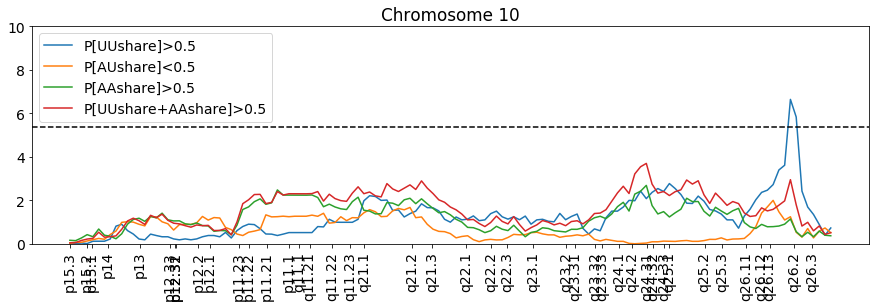

In [345]:
import matplotlib


chrom = '10'
chrom_index = chroms.index(chrom)


plt.figure(figsize=(15, 4))


for index in [0, 1, 2, 6]:
    #ax = plt.subplot(3, 1, index+1)
    plt.plot(xs[include_in_display & (all_chroms == chrom_index)], -np.log10(all_combined_pvalues[include_in_display & (all_chroms == chrom_index), index]), label=labels[index])

plt.ylim([0, 10])
plt.xticks([chrom_to_start_pos[chrom_index]+x[1] for x in cyto if x[0]==chrom], 
       [x[3] for x in cyto if x[0]==chrom], rotation=90)
plt.axhline(bonferonni_cutoff, color='black', linestyle='--')
plt.legend()
plt.title('Chromosome %s' % chrom)
#plt.tight_layout()
plt.show()


# check haplotypes

In [257]:
import scipy.sparse as sparse
A = sparse.load_npz('../../DATA/spark/genotypes/chr.10.0.gen.npz')

coordinates = np.load('../../DATA/spark/genotypes/chr.10.0.gen.coordinates.npy')
snp_positions = coordinates[:, 1]
is_snp = coordinates[:, 2]==1
is_pass = coordinates[:, 3]==1
snp_positions = snp_positions[is_snp & is_pass]
A = A[:, is_snp & is_pass]

indices = (snp_positions>=125000000) & (snp_positions<=126500000)
snp_positions = snp_positions[indices]
A = A[:, indices]

print(A.shape, snp_positions.shape)

(13249, 426) (426,)


In [278]:
print(np.isin(snp_positions, ihart_snp_positions).shape,
     np.isin(ihart_snp_positions, snp_positions).shape)

(426,) (38508,)


In [279]:
new_ihart_A = -np.ones((ihart_A.shape[0], A.shape[1]))
new_ihart_A[:, np.isin(snp_positions, ihart_snp_positions)] = ihart_A[:, np.isin(ihart_snp_positions, snp_positions)].A


In [280]:
with open('../split_gen_spark/chr.10.gen.samples.txt', 'r') as f:
    sample_id_to_index = dict([(x.strip(), i) for i, x in enumerate(f)])
    
with open('../split_gen_ihart/chr.10.gen.samples.txt', 'r') as f:
    ihart_sample_id_to_index = dict([(x.strip(), i) for i, x in enumerate(f)])

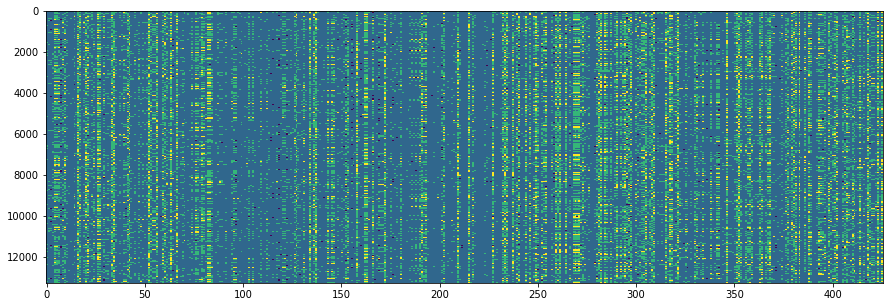

In [281]:
plt.figure(figsize=(15, 5))
plt.imshow(A.A, aspect='auto')
plt.show()

In [282]:
import importlib.util

spec = importlib.util.spec_from_file_location("input_output", "../phase/input_output.py")
input_output = importlib.util.module_from_spec(spec)
spec.loader.exec_module(input_output)


families = input_output.pull_families('%s/chr.%s.gen.samples.txt' % ('../split_gen_spark', '10'), 
                                    '../data/spark.ped.quads.ped')
ihart_families = input_output.pull_families('%s/chr.%s.gen.samples.txt' % ('../split_gen_ihart', '10'), 
                                    '../data/v34.vcf.ped.quads.ped')

families pulled 4167
families pulled 2102


In [283]:
import numpy as np
import json

spec = importlib.util.spec_from_file_location("ancestral_variants", "../phase/ancestral_variants.py")
ancestral_variants = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ancestral_variants)

spec = importlib.util.spec_from_file_location("inheritance_states", "../phase/inheritance_states.py")
inheritance_states = importlib.util.module_from_spec(spec)
spec.loader.exec_module(inheritance_states)

spec = importlib.util.spec_from_file_location("genotypes", "../phase/genotypes.py")
genotypes = importlib.util.module_from_spec(spec)
spec.loader.exec_module(genotypes)

spec = importlib.util.spec_from_file_location("losses", "../phase/losses.py")
losses = importlib.util.module_from_spec(spec)
spec.loader.exec_module(losses)

with open('../parameter_estimation/params/spark_multiloss_params.json', 'r') as f:
    params = json.load(f)

with open('../parameter_estimation/params/ihart_multiloss_params.json', 'r') as f:
    ihart_params = json.load(f)

In [284]:
family_to_index = dict([(x.id, i) for i, x in enumerate(families)])
family_to_state = -np.ones((len(families), 13))
with open('../phased_spark_quads/chr.10.familysize.4.phased.txt', 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split('\t')
        start_pos, end_pos = int(pieces[14]), int(pieces[15])
        if (start_pos<=125000000) and (end_pos>=126500000):
            state = np.array([int(x) for x in pieces[1:14]])
            if state[-1] == 0 and np.all(state>=0):
                family_to_state[family_to_index['.'.join(pieces[0].split('.')[:3])], :] = state
            
ihart_family_to_index = dict([(x.id, i) for i, x in enumerate(ihart_families)])
ihart_family_to_state = -np.ones((len(ihart_families), 13))
with open('../phased_ihart_quads/chr.10.familysize.4.phased.txt', 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split('\t')
        start_pos, end_pos = int(pieces[14]), int(pieces[15])
        if (start_pos<=125000000) and (end_pos>=126500000):
            state = np.array([int(x) for x in pieces[1:14]])
            if state[-1] == 0 and np.all(state>=0):
                ihart_family_to_state[ihart_family_to_index['.'.join(pieces[0].split('.')[:3])], :] = state
            
                

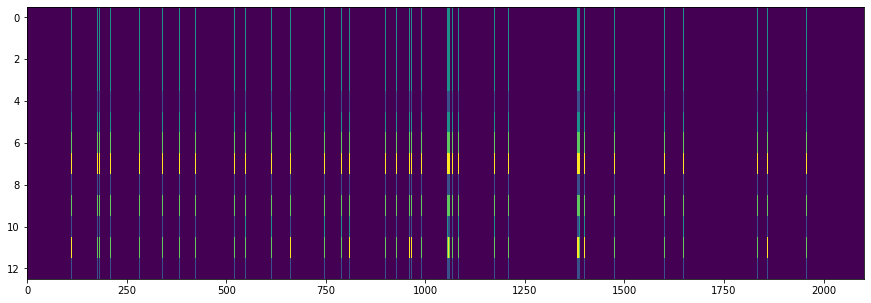

In [285]:
plt.figure(figsize=(15, 5))
plt.imshow(ihart_family_to_state.T, aspect='auto')
plt.show()

In [286]:
gens = genotypes.Genotypes(len(families[0]))
states = inheritance_states.InheritanceStates(families[0], True, True, 1)
loss = losses.LazyLoss(states, gens, families[0], params, 1)
ihart_loss = losses.LazyLoss(states, gens, ihart_families[0], ihart_params, 2)


genotypes (241, 4)
inheritance states (64, 9)
SP0000051	0/0		0/1		1/1		./.
0/0	0.00	3.95	5.14	3.13
0/1	3.99	0.00	4.08	2.61
1/1	3.58	3.19	0.01	3.19
-/0	0.00	3.95	5.14	3.13
-/1	3.58	3.19	0.01	3.19
-/-	3.19	4.36	3.95	0.00
SP0000241	0/0		0/1		1/1		./.
0/0	0.00	3.95	5.29	2.59
0/1	4.12	0.00	3.83	2.23
1/1	3.62	3.19	0.01	2.31
-/0	0.00	3.95	5.29	2.59
-/1	3.62	3.19	0.01	2.31
-/-	3.19	4.45	3.95	0.00
SP0000027	0/0		0/1		1/1		./.
0/0	0.00	4.38	5.37	2.50
0/1	4.13	0.00	4.10	2.47
1/1	3.78	3.19	0.00	2.44
-/0	0.00	4.38	5.37	2.50
-/1	3.78	3.19	0.00	2.44
-/-	3.19	4.58	4.38	0.00
SP0000034	0/0		0/1		1/1		./.
0/0	0.01	3.53	5.37	1.95
0/1	3.97	0.00	3.62	2.06
1/1	3.79	3.19	0.01	1.75
-/0	0.01	3.53	5.37	1.95
-/1	3.79	3.19	0.01	1.75
-/-	3.19	4.58	3.53	0.00
losses (64, 241)
perfect matches 204
perfect_match_indices (64, 16)
AU000101	0/0		0/1		1/1		./.
0/0	0.00-0.00	3.86-2.69	7.51-5.85	3.22-2.19
0/1	2.09-1.13	0.01-0.06	2.47-1.56	2.93-1.55
1/1	5.75-3.85	3.45-2.05	0.00-0.01	3.15-3.92
-/0	0.00-0.00	3.86-2.69	7.51-5.85	

In [287]:
ancs = -np.ones((len(families), 4, snp_positions.shape[0]))

#for family in families: 
for family_index, family in enumerate(families):
    family_gen = A[[sample_id_to_index[x] for x in family.individuals], :].A
    if np.all(family_to_state[family_index, :]>=0):
        state = states.get_original_state(family_to_state[family_index, :])
        variants = ancestral_variants.AncestralVariants(states, gens, loss, family, state)
        for i in range(snp_positions.shape[0]):
            if np.all(family_gen[:, i]>=0):
                ancs[family_index, :, i] = variants(tuple(family_gen[:, i]))
                
    if family_index%1000==0:
        print(family_index)
        
            


0
1000
2000
3000
4000


In [288]:
ihart_ancs = -np.ones((len(ihart_families), 4, snp_positions.shape[0]))
#for family in families: 
for family_index, family in enumerate(ihart_families):
    family_gen = new_ihart_A[[ihart_sample_id_to_index[x] for x in family.individuals], :].astype(int)
    if np.all(ihart_family_to_state[family_index, :]>=0):
        state = states.get_original_state(ihart_family_to_state[family_index, :])
        variants = ancestral_variants.AncestralVariants(states, gens, loss, family, state)
        for i in range(snp_positions.shape[0]):
            if np.all(family_gen[:, i]>=0):
                ihart_ancs[family_index, :, i] = variants(tuple(family_gen[:, i]))
                
    if family_index%1000==0:
        print(family_index)

0
1000
2000


In [289]:
families_of_interest = np.any(ancs>=0, axis=(1, 2))
families = [families[i] for i in np.where(families_of_interest)[0]]
ancs = ancs[families_of_interest, :, :]
family_to_state = family_to_state[families_of_interest, :]
print(ancs.shape, family_to_state.shape, len(families))

(3395, 4, 426) (3395, 13) 3395


In [290]:
ihart_families_of_interest = np.any(ihart_ancs>=0, axis=(1, 2))
ihart_families = [ihart_families[i] for i in np.where(ihart_families_of_interest)[0]]
ihart_ancs = ihart_ancs[ihart_families_of_interest, :, :]
ihart_family_to_state = ihart_family_to_state[ihart_families_of_interest, :]
print(ihart_ancs.shape, ihart_family_to_state.shape, len(ihart_families))

(82, 4, 426) (82, 13) 82


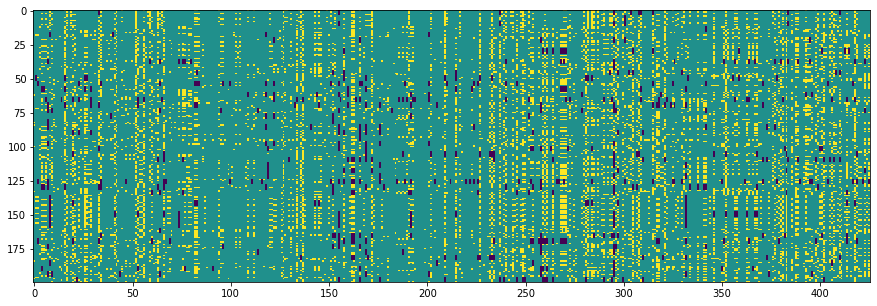

(array([-1.,  0.,  1.]), array([ 184664, 4874425,  725991]))


In [291]:
plt.figure(figsize=(15, 5))
plt.imshow(np.vstack(ancs)[:200], aspect='auto')
plt.show()
print(np.unique(ancs, return_counts=True))

In [296]:
for p in snp_positions:
    print('chr10:%d-%d' % (p, p))

chr10:125000451-125000451
chr10:125001106-125001106
chr10:125002707-125002707
chr10:125006504-125006504
chr10:125007104-125007104
chr10:125008303-125008303
chr10:125023064-125023064
chr10:125023588-125023588
chr10:125026867-125026867
chr10:125027060-125027060
chr10:125027123-125027123
chr10:125028763-125028763
chr10:125029145-125029145
chr10:125030347-125030347
chr10:125032348-125032348
chr10:125033769-125033769
chr10:125041922-125041922
chr10:125045850-125045850
chr10:125048542-125048542
chr10:125049902-125049902
chr10:125050580-125050580
chr10:125050944-125050944
chr10:125051161-125051161
chr10:125052972-125052972
chr10:125054626-125054626
chr10:125054819-125054819
chr10:125059240-125059240
chr10:125060593-125060593
chr10:125060760-125060760
chr10:125063911-125063911
chr10:125065282-125065282
chr10:125065493-125065493
chr10:125066375-125066375
chr10:125067164-125067164
chr10:125068682-125068682
chr10:125073521-125073521
chr10:125074641-125074641
chr10:125075345-125075345
chr10:125075

(13580, 426)


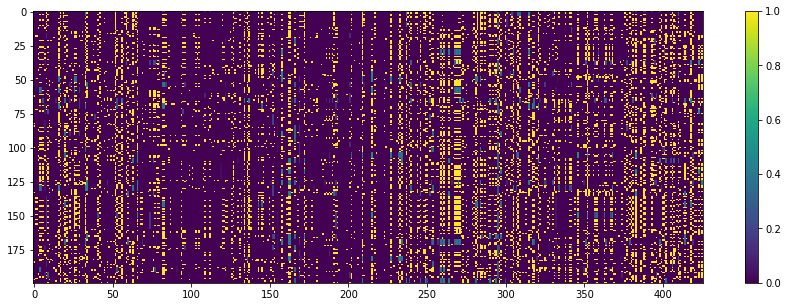

In [292]:
# cluster phased data

all_ancestors = np.vstack(ancs)

# fill in missing values with mean
for i in range(all_ancestors.shape[1]):
    all_ancestors[all_ancestors[:, i] == -1, i] = np.sum(all_ancestors[:, i]==1)/np.sum(all_ancestors[:, i]>=0)
print(all_ancestors.shape)

plt.figure(figsize=(15, 5))
plt.imshow(all_ancestors[:200], aspect='auto')
plt.colorbar()
plt.show()


In [293]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    cluster_labels = kmeans.fit_predict(all_ancestors)
    silhouette_avg = silhouette_score(all_ancestors, cluster_labels)
    print(i, silhouette_avg)

2 0.036612112690995194
3 0.032462114238665206
4 0.025766119880828536
5 0.029741880422584462
6 0.029890386414232435
7 0.030396579946016668
8 0.030853545964692863
9 0.030111162084634532
10 0.03263308302464343


In [294]:
n_clusters=2
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(all_ancestors)
silhouette_avg = silhouette_score(all_ancestors, cluster_labels)
print(silhouette_avg)

0.036612112690995194


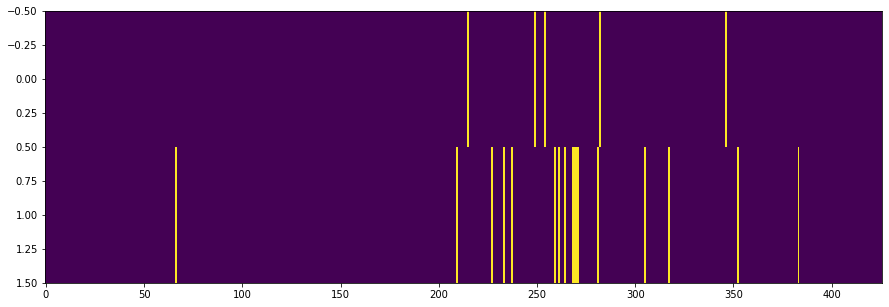

In [254]:
plt.figure(figsize=(15, 5))
plt.imshow(kmeans.cluster_centers_>0.5, aspect='auto')
#plt.colorbar()
plt.show()


In [258]:
print(all_ancestors.shape, kmeans.cluster_centers_.shape)

(13580, 426) (2, 426)


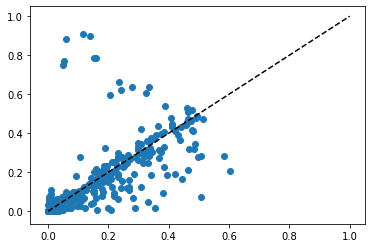

In [265]:
plt.scatter(np.sum(all_ancestors[cluster_labels==0, :], axis=0)/np.sum(cluster_labels==0),
            np.sum(all_ancestors[cluster_labels==1, :], axis=0)/np.sum(cluster_labels==1))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

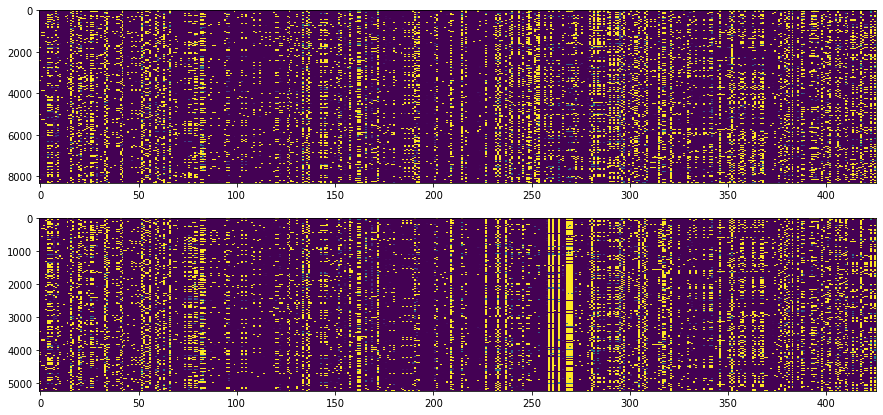

In [262]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.imshow(all_ancestors[cluster_labels==0, :], aspect='auto')

plt.subplot(2, 1, 2)
plt.imshow(all_ancestors[cluster_labels==1, :], aspect='auto')

#plt.colorbar()
plt.show()


In [239]:
print(len(families)*4, cluster_labels.shape[0])

13580 13580


In [240]:
sample_id_to_affected = dict()
with open('../data/spark.ped.quads.ped', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 5:
            fam_id, child_id, f_id, m_id, sex, phen = pieces[:6]
            sample_id_to_affected[child_id] = phen


In [241]:
# try a TDT

# haplotype, mat/pat, unaff/aff, notrans/trans
contingency = np.zeros((n_clusters, 2, 2, 2))
couples = []
for i, (family, state) in enumerate(zip(families, family_to_state)):
    m1, m2, p1, p2 = cluster_labels[(4*i):(4*(i+1))]
    children_aff = [int(sample_id_to_affected[x]=='2') for x in family.individuals[2:]]
    mat_phase_indices = [8, 10]
    pat_phase_indices = [9, 11]
    if m1 != m2:
        contingency[m1, 0, children_aff, (state[mat_phase_indices]==0).astype(int)] += 1
        contingency[m2, 0, children_aff, (state[mat_phase_indices]==1).astype(int)] += 1
    
    if p1 != p2:
        contingency[p1, 1, children_aff, (state[pat_phase_indices]==2).astype(int)] += 1
        contingency[p2, 1, children_aff, (state[pat_phase_indices]==3).astype(int)] += 1
    couples.append((m1, m2, p1, p2))
    
print(Counter(couples))

Counter({(0, 0, 0, 0): 558, (0, 0, 1, 0): 314, (0, 0, 0, 1): 302, (1, 0, 0, 0): 300, (0, 1, 0, 0): 272, (0, 0, 1, 1): 253, (1, 0, 1, 0): 188, (0, 1, 0, 1): 183, (1, 1, 0, 0): 171, (1, 1, 0, 1): 143, (0, 1, 1, 1): 140, (1, 0, 1, 1): 129, (1, 1, 1, 1): 115, (1, 1, 1, 0): 113, (1, 0, 0, 1): 110, (0, 1, 1, 0): 104})


In [242]:
# unaff/aff, all/mat/pat
pvalues = np.ones((n_clusters, 2, 3))
for i in range(contingency.shape[0]):
    pvalues[i, 0, 0] = scipy.stats.binom_test(np.sum(contingency[i, :, 0, 1]), 
                                        np.sum(contingency[i, :, 0, :]), p=0.5, alternative='greater')
    pvalues[i, 1, 0] = scipy.stats.binom_test(np.sum(contingency[i, :, 1, 1]), 
                                        np.sum(contingency[i, :, 1, :]), p=0.5, alternative='greater')
    
    pvalues[i, 0, 1] = scipy.stats.binom_test(contingency[i, 0, 0, 1], 
                                        np.sum(contingency[i, 0, 0, :]), p=0.5, alternative='greater')
    pvalues[i, 1, 1] = scipy.stats.binom_test(contingency[i, 0, 1, 1], 
                                        np.sum(contingency[i, 0, 1, :]), p=0.5, alternative='greater')
    
    pvalues[i, 0, 2] = scipy.stats.binom_test(contingency[i, 1, 0, 1],
                                        np.sum(contingency[i, 1, 0, :]), p=0.5, alternative='greater')
    pvalues[i, 1, 1] = scipy.stats.binom_test(contingency[i, 1, 1, 1], 
                                        np.sum(contingency[i, 1, 1, :]), p=0.5, alternative='greater')

In [272]:
# haplotype, mat/pat, unaff/aff, notrans/trans

print(contingency[0, :, 0, :])
print(scipy.stats.chi2_contingency(contingency[0, :, 0, :]))
# we see more maternal transmissions of hap1 and paternal transmissions of hap2 to unaffected children

print()
print(contingency[0, :, 1, :])
print(scipy.stats.chi2_contingency(contingency[0, :, 1, :]))
# transmissions to affected children are normal

[[633. 557.]
 [558. 624.]]
(8.259329121283951, 0.004054310787902924, 1, array([[597.5084317, 592.4915683],
       [593.4915683, 588.5084317]]))

[[760. 757.]
 [798. 752.]]
(0.5342854311479969, 0.4648107265339544, 1, array([[770.61819367, 746.38180633],
       [787.38180633, 762.61819367]]))


In [243]:
for i in range(n_clusters):
    print(i)
    print('aff', scipy.stats.binom_test(np.sum(contingency[i, :, 1, 1]), 
                                        np.sum(contingency[i, :, 1, :]), p=0.5, alternative='greater'))
    print('unaff', scipy.stats.binom_test(np.sum(contingency[i, :, 0, 1]), 
                                        np.sum(contingency[i, :, 0, :]), p=0.5, alternative='greater'))
    
    print('aff mat', scipy.stats.binom_test(contingency[i, 0, 1, 1], 
                                        np.sum(contingency[i, 0, 1, :]), p=0.5, alternative='greater'))
    print('unaff mat', scipy.stats.binom_test(contingency[i, 0, 0, 1], 
                                        np.sum(contingency[i, 0, 0, :]), p=0.5, alternative='greater'))
    print(contingency[i, 0, 0, 0], contingency[i, 0, 0, 1])
    
    print('aff pat', scipy.stats.binom_test(contingency[i, 1, 1, 1], 
                                        np.sum(contingency[i, 1, 1, :]), p=0.5, alternative='greater'))
    print('unaff pat', scipy.stats.binom_test(contingency[i, 1, 0, 1], 
                                        np.sum(contingency[i, 1, 0, :]), p=0.5, alternative='greater'))
    print(contingency[i, 1, 0, 0], contingency[i, 1, 0, 1])
          
          
          

0
aff 0.8166946666361515
unaff 0.5893411099029484
aff mat 0.5408969415562865
unaff mat 0.9872170119428533
633.0 557.0
aff pat 0.883727457693078
unaff pat 0.029314506254077922
558.0 624.0
1
aff 0.19304630574012527
unaff 0.42669821821862275
aff mat 0.47952458788978813
unaff mat 0.014825945978505228
557.0 633.0
aff pat 0.1265151580699698
unaff pat 0.9743629930865457
624.0 558.0


In [274]:
print('hap1')
for i in np.where(kmeans.cluster_centers_[0, :]>0.5)[0]:
    print(snp_positions[i])
print('hap2')
for i in np.where(kmeans.cluster_centers_[1, :]>0.5)[0]:
    print(snp_positions[i])

hap1
125793866
126041165
126045944
126118602
126227898
hap2
125167686
125785806
125874940
125965967
125972208
126054095
126054479
126060783
126080976
126084807
126088331
126088452
126115962
126157206
126177217
126240569
126333006


In [ ]:
print()

# some theory

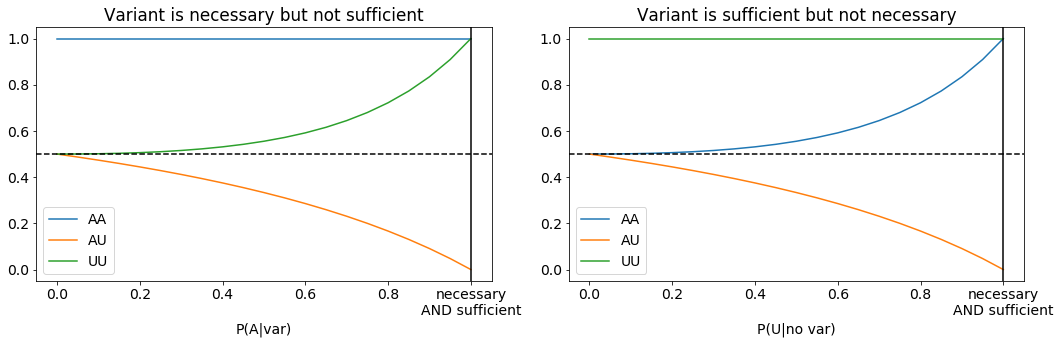

In [4374]:
plt.figure(figsize=(15, 5))

q = np.arange(0, 1.05, 0.05)

plt.subplot(1, 2, 1)
plt.title('Variant is necessary but not sufficient')
plt.plot(q, np.ones(q.shape), label='AA')
plt.plot(q, (1-q)/(2-q), label='AU')
plt.plot(q, ((1-q)**2 + 1)/(2-q)**2, label='UU')
plt.xlabel('P(A|var)')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(1, color='black')
plt.legend()
plt.xticks(np.arange(0, 1.2, 0.2), ['necessary\nAND sufficient' if x==1 else '%0.1f' % x for x in np.arange(0, 1.2, 0.2)])

plt.subplot(1, 2, 2)
plt.title('Variant is sufficient but not necessary')
plt.plot(1-q, (1/(1+q))**2 + (q/(1+q))**2, label='AA')
plt.plot(1-q, q/(1+q), label='AU')
plt.plot(1-q, np.ones(q.shape), label='UU')
plt.xlabel('P(U|no var)')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(1, color='black')
plt.legend()
plt.xticks(np.arange(0, 1.2, 0.2), ['necessary\nAND sufficient' if x==1 else '%0.1f' % x for x in np.arange(0, 1.2, 0.2)])

plt.tight_layout()
plt.show()

11.350463840000007
15.999999999999996
11.350463840000007
15.999999999999996


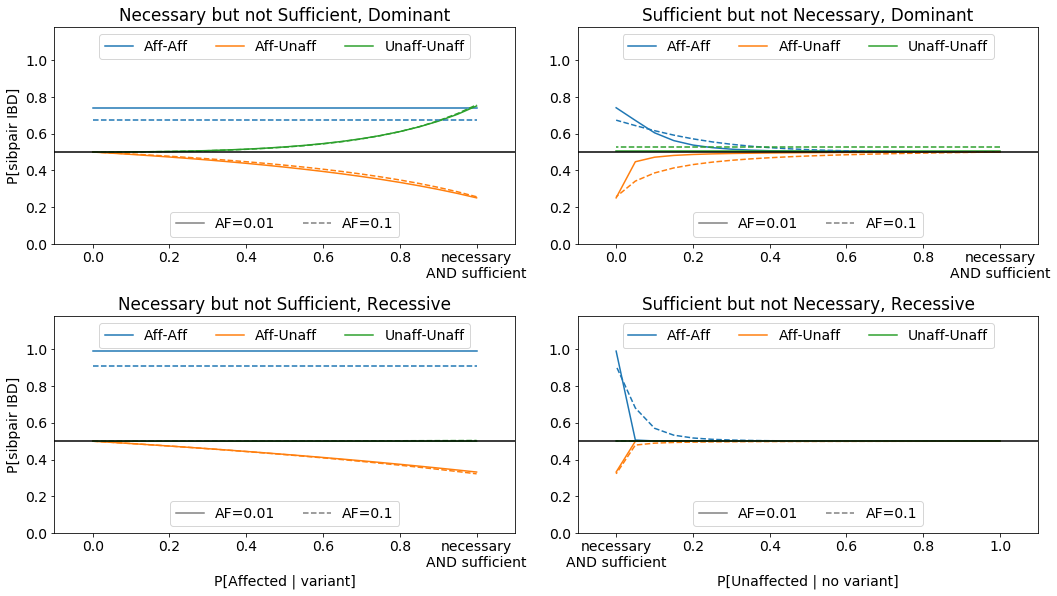

In [4471]:
from itertools import product
import matplotlib

matplotlib.rcParams.update({'font.size': 14})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def plot_necesary_not_sufficient(p, linestyle, disease_variants):
    # NECESSARY BUT NOT SUFFICIENT
    q = np.arange(0, 1.05, 0.05)

    # m1, m2, p1, p2, child1_mat, child1_pat, child2_mat, child2_pat
    options = list(product(*([[0, 1]]*4 + [[0, 1], [2, 3]]*2)))
    options = [x for x in options if np.sum(x[:4])>0]
    par_gen_prob = [np.product([x*p + (1-x)*(1-p) for x in opt[:4]]) for opt in options]

    # novar/var, U/A
    contingency = np.array([[1/(2-q), np.zeros(q.shape)],
                            [(1-q)/(2-q), np.ones(q.shape)]])

    # AA/AU/UU, nomatch/match
    match = np.zeros((3, 2, q.shape[0]))
    for opt, pargen in zip(options, par_gen_prob):
        child1_hasvar = int((opt[opt[4]] + opt[opt[5]])>=disease_variants)
        child2_hasvar = int((opt[opt[6]] + opt[opt[7]])>=disease_variants)

        #A-A
        prob = pargen * contingency[child1_hasvar, 1] * contingency[child2_hasvar, 1]
        match[0, int(opt[4] == opt[6])] += prob
        match[0, int(opt[5] == opt[7])] += prob

        #A-U
        prob = pargen * contingency[child1_hasvar, 1] * contingency[child2_hasvar, 0]
        match[1, int(opt[4] == opt[6])] += prob
        match[1, int(opt[5] == opt[7])] += prob

        #U-U
        prob = pargen * contingency[child1_hasvar, 0] * contingency[child2_hasvar, 0]
        match[2, int(opt[4] == opt[6])] += prob
        match[2, int(opt[5] == opt[7])] += prob

    plt.plot(q, match[0, 1]/(match[0, 0]+match[0, 1]), color=colors[0], linestyle=linestyle)
    plt.plot(q, match[1, 1]/(match[1, 0]+match[1, 1]), color=colors[1], linestyle=linestyle)
    plt.plot(q, match[2, 1]/(match[2, 0]+match[2, 1]), color=colors[2], linestyle=linestyle)

def plot_sufficient_not_necesary(p, z, linestyle, disease_variants):
    # p is allele frequency
    # z is percent of autism cases caused by this variant
    
    # SUFFICIENT BUT NOT NECFESSARY
    q = np.arange(0, 1.05, 0.05)

    # m1, m2, p1, p2, child1_mat, child1_pat, child2_mat, child2_pat
    options = list(product(*([[0, 1]]*4 + [[0, 1], [2, 3]]*2)))
    par_gen_prob = [np.product([x*p + (1-x)*(1-p) for x in opt[:4]]) for opt in options]
    prob_has_variant = np.sum([p for p, opt in zip(par_gen_prob, options) if np.sum(opt[:4])>0])/16
    par_gen_prob = [min(1-prob_has_variant, 1-z) if np.sum(opt[:4])==0 else p for p, opt in zip(par_gen_prob, options)]
    print(np.sum(par_gen_prob))
    
    # novar/var, U/A
    contingency = np.array([[np.ones(q.shape), (1-q)/(2-q)],
                            [np.zeros(q.shape), 1/(2-q)]])

    # AA/AU/UU, nomatch/match
    match = np.zeros((3, 2, q.shape[0]))
    for opt, pargen in zip(options, par_gen_prob):
        child1_hasvar = int((opt[opt[4]] + opt[opt[5]])>=disease_variants)
        child2_hasvar = int((opt[opt[6]] + opt[opt[7]])>=disease_variants)

        #A-A
        prob = pargen * contingency[child1_hasvar, 1] * contingency[child2_hasvar, 1]
        match[0, int(opt[4] == opt[6])] += prob
        match[0, int(opt[5] == opt[7])] += prob

        #A-U
        prob = pargen * contingency[child1_hasvar, 1] * contingency[child2_hasvar, 0]
        match[1, int(opt[4] == opt[6])] += prob
        match[1, int(opt[5] == opt[7])] += prob

        #U-U
        prob = pargen * contingency[child1_hasvar, 0] * contingency[child2_hasvar, 0]
        match[2, int(opt[4] == opt[6])] += prob
        match[2, int(opt[5] == opt[7])] += prob

    plt.plot(1-q, match[0, 1]/(match[0, 0]+match[0, 1]), color=colors[0], linestyle=linestyle)
    plt.plot(1-q, match[1, 1]/(match[1, 0]+match[1, 1]), color=colors[1], linestyle=linestyle)
    plt.plot(1-q, match[2, 1]/(match[2, 0]+match[2, 1]), color=colors[2], linestyle=linestyle)



plt.figure(figsize=(15, 8.5))
z = 0.33
plt.subplot(2, 2, 1)
plot_necesary_not_sufficient(0.01, '-', disease_variants=1)
plot_necesary_not_sufficient(0.1, '--', disease_variants=1)
#plot_necesary_not_sufficient(0.5, '-.', disease_variants=1)

plt.title('Necessary but not Sufficient, Dominant')
plt.axhline(0.5, color='black')
plt.xticks(np.arange(0, 1.2, 0.2), ['necessary\nAND sufficient' if x==1 else '%0.1f' % x for x in np.arange(0, 1.2, 0.2)])
plt.xlim([-0.1, 1.1])
plt.ylim([0, 1.18])
#plt.xlabel('P[Affected | variant]')
plt.ylabel('P[sibpair IBD]')

lines = [matplotlib.lines.Line2D([0], [0], color=colors[0], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[1], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[2], linestyle='-')]
labels = ['Aff-Aff', 'Aff-Unaff', 'Unaff-Unaff']
first_legend = plt.legend(lines, labels, loc='upper center', ncol=3)
plt.gca().add_artist(first_legend)
lines = [matplotlib.lines.Line2D([0], [0], color='gray', linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color='gray', linestyle='--')]
labels = ['AF=0.01', 'AF=0.1']
plt.legend(lines, labels, loc='lower center', ncol=3)

plt.subplot(2, 2, 2)
plot_sufficient_not_necesary(0.01, z, '-', disease_variants=1)
plot_sufficient_not_necesary(0.1, z, '--', disease_variants=1)
#plot_sufficient_not_necesary(0.5, z, '-.', disease_variants=1)

plt.title('Sufficient but not Necessary, Dominant')
plt.axhline(0.5, color='black')
plt.xticks(np.arange(0, 1.2, 0.2), ['necessary\nAND sufficient' if x==1 else '%0.1f' % x for x in np.arange(0, 1.2, 0.2)])
plt.xlim([-0.1, 1.1])
plt.ylim([0, 1.18])
#plt.xlabel('P[Unaffected | no variant]')
#plt.ylabel('P[sibpair IBD]')

lines = [matplotlib.lines.Line2D([0], [0], color=colors[0], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[1], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[2], linestyle='-')]
labels = ['Aff-Aff', 'Aff-Unaff', 'Unaff-Unaff']
first_legend = plt.legend(lines, labels, loc='upper center', ncol=3)
plt.gca().add_artist(first_legend)
lines = [matplotlib.lines.Line2D([0], [0], color='gray', linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color='gray', linestyle='--')]
labels = ['AF=0.01', 'AF=0.1']
plt.legend(lines, labels, loc='lower center', ncol=3)

plt.subplot(2, 2, 3)
plot_necesary_not_sufficient(0.01, '-', disease_variants=2)
plot_necesary_not_sufficient(0.1, '--', disease_variants=2)
#plot_necesary_not_sufficient(0.5, '-.', disease_variants=2)

plt.title('Necessary but not Sufficient, Recessive')
plt.axhline(0.5, color='black')
plt.xticks(np.arange(0, 1.2, 0.2), ['necessary\nAND sufficient' if x==1 else '%0.1f' % x for x in np.arange(0, 1.2, 0.2)])
plt.xlim([-0.1, 1.1])
plt.ylim([0, 1.18])
plt.xlabel('P[Affected | variant]')
plt.ylabel('P[sibpair IBD]')

lines = [matplotlib.lines.Line2D([0], [0], color=colors[0], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[1], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[2], linestyle='-')]
labels = ['Aff-Aff', 'Aff-Unaff', 'Unaff-Unaff']
first_legend = plt.legend(lines, labels, loc='upper center', ncol=3)
plt.gca().add_artist(first_legend)
lines = [matplotlib.lines.Line2D([0], [0], color='gray', linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color='gray', linestyle='--')]
labels = ['AF=0.01', 'AF=0.1']
plt.legend(lines, labels, loc='lower center', ncol=3)

plt.subplot(2, 2, 4)
plot_sufficient_not_necesary(0.01, z, '-', disease_variants=2)
plot_sufficient_not_necesary(0.1, z, '--', disease_variants=2)
#plot_sufficient_not_necesary(0.5, z, '-.', disease_variants=2)

plt.title('Sufficient but not Necessary, Recessive')
plt.axhline(0.5, color='black')
plt.xticks(np.arange(0, 1.2, 0.2), ['necessary\nAND sufficient' if x==0 else '%0.1f' % x for x in np.arange(0, 1.2, 0.2)])
plt.xlim([-0.1, 1.1])
plt.ylim([0, 1.18])
plt.xlabel('P[Unaffected | no variant]')
#plt.ylabel('P[sibpair IBD]')

lines = [matplotlib.lines.Line2D([0], [0], color=colors[0], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[1], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[2], linestyle='-')]
labels = ['Aff-Aff', 'Aff-Unaff', 'Unaff-Unaff']
first_legend = plt.legend(lines, labels, loc='upper center', ncol=3)
plt.gca().add_artist(first_legend)
lines = [matplotlib.lines.Line2D([0], [0], color='gray', linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color='gray', linestyle='--')]
labels = ['AF=0.01', 'AF=0.1']
plt.legend(lines, labels, loc='lower center', ncol=3)

plt.tight_layout()
plt.show()


TypeError: plot_sufficient_not_necesary() missing 1 required positional argument: 'linestyle'

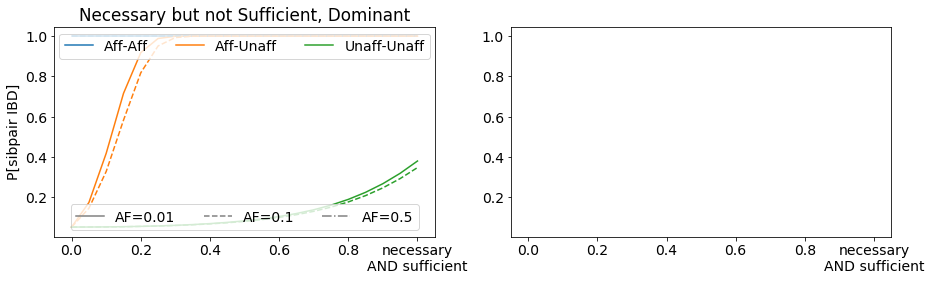

In [4452]:
from itertools import product
import matplotlib

matplotlib.rcParams.update({'font.size': 14})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def plot_necesary_not_sufficient(p, linestyle, disease_variants):
    # NECESSARY BUT NOT SUFFICIENT
    q = np.arange(0, 1.05, 0.05)

    # m1, m2, p1, p2, child1_mat, child1_pat, child2_mat, child2_pat
    options = list(product(*([[0, 1]]*4 + [[0, 1], [2, 3]]*2)))
    par_gen_prob = [np.product([x*p + (1-x)*(1-p) for x in opt[:4]]) for opt in options]
    prob_has_variant = np.sum([p for p, opt in zip(par_gen_prob, options) if np.sum(opt[:4])>0])/16
    par_gen_prob = [min((1-prob_has_variant), z*prob_has_variant/16) if np.sum(opt[:4])==0 else p for p, opt in zip(par_gen_prob, options)]

    # novar/var, U/A
    contingency = np.array([[1/(2-q), np.zeros(q.shape)],
                            [(1-q)/(2-q), np.ones(q.shape)]])

    # AA/AU/UU, nomatch/match
    match = np.zeros((3, 2, q.shape[0]))
    for opt, pargen in zip(options, par_gen_prob):
        child1_hasvar = int((opt[opt[4]] + opt[opt[5]])>=disease_variants)
        child2_hasvar = int((opt[opt[6]] + opt[opt[7]])>=disease_variants)

        #A-A
        prob = pargen * contingency[child1_hasvar, 1] * contingency[child2_hasvar, 1]
        match[0, int(opt[4] == opt[6])] += prob
        match[0, int(opt[5] == opt[7])] += prob

        #A-U
        prob = pargen * contingency[child1_hasvar, 1] * contingency[child2_hasvar, 0]
        match[1, int(opt[4] == opt[6])] += prob
        match[1, int(opt[5] == opt[7])] += prob

        #U-U
        prob = pargen * contingency[child1_hasvar, 0] * contingency[child2_hasvar, 0]
        match[2, int(opt[4] == opt[6])] += prob
        match[2, int(opt[5] == opt[7])] += prob

    n_AA = 675
    n_AU = 3093
    n_UU = 89
    
    p_AA = match[0, 1, :]/(match[0, 0, :]+match[0, 1, :])
    p_AU = match[1, 1, :]/(match[1, 0, :]+match[1, 1, :])
    p_UU = match[2, 1, :]/(match[2, 0, :]+match[2, 1, :])
        
    delta_AA = np.abs(0.5-p_AA)
    delta_AU = np.abs(0.5-p_AU)
    delta_UU = np.abs(0.5-p_UU)


    power_AA = scipy.stats.norm.cdf((delta_AA*np.sqrt(n_AA) - 1.645*np.sqrt(0.5*0.5))/np.sqrt(p_AA*(1-p_AA)))
    power_AU = scipy.stats.norm.cdf((delta_AU*np.sqrt(n_AU) - 1.645*np.sqrt(0.5*0.5))/np.sqrt(p_AU*(1-p_AU)))
    power_UU = scipy.stats.norm.cdf((delta_UU*np.sqrt(n_UU) - 1.645*np.sqrt(0.5*0.5))/np.sqrt(p_UU*(1-p_UU)))
    
    plt.plot(q, power_AA, color=colors[0], linestyle=linestyle)
    plt.plot(q, power_AU, color=colors[1], linestyle=linestyle)
    plt.plot(q, power_UU, color=colors[2], linestyle=linestyle)

def plot_sufficient_not_necesary(p, z, linestyle, disease_variants):
    # p is allele frequency
    # z is percent of autism cases caused by this variant
    
    # SUFFICIENT BUT NOT NECFESSARY
    q = np.arange(0, 1.05, 0.05)

    # m1, m2, p1, p2, child1_mat, child1_pat, child2_mat, child2_pat
    options = list(product(*([[0, 1]]*4 + [[0, 1], [2, 3]]*2)))
    par_gen_prob = [np.product([x*p + (1-x)*(1-p) for x in opt[:4]]) for opt in options]
    prob_has_variant = np.sum([p for p, opt in zip(par_gen_prob, options) if np.sum(opt[:4])>0])/16
    par_gen_prob = [min((1-prob_has_variant), z*prob_has_variant/16) if np.sum(opt[:4])==0 else p for p, opt in zip(par_gen_prob, options)]
    
    # novar/var, U/A
    contingency = np.array([[np.ones(q.shape), (1-q)/(2-q)],
                            [np.zeros(q.shape), 1/(2-q)]])

    # AA/AU/UU, nomatch/match
    match = np.zeros((3, 2, q.shape[0]))
    for opt, pargen in zip(options, par_gen_prob):
        child1_hasvar = int((opt[opt[4]] + opt[opt[5]])>=disease_variants)
        child2_hasvar = int((opt[opt[6]] + opt[opt[7]])>=disease_variants)

        #A-A
        prob = pargen * contingency[child1_hasvar, 1] * contingency[child2_hasvar, 1]
        match[0, int(opt[4] == opt[6])] += prob
        match[0, int(opt[5] == opt[7])] += prob

        #A-U
        prob = pargen * contingency[child1_hasvar, 1] * contingency[child2_hasvar, 0]
        match[1, int(opt[4] == opt[6])] += prob
        match[1, int(opt[5] == opt[7])] += prob

        #U-U
        prob = pargen * contingency[child1_hasvar, 0] * contingency[child2_hasvar, 0]
        match[2, int(opt[4] == opt[6])] += prob
        match[2, int(opt[5] == opt[7])] += prob
        
    n_AA = 675
    n_AU = 3093
    n_UU = 89
    
    p_AA = match[0, 1, :]/(match[0, 0, :]+match[0, 1, :])
    p_AU = match[1, 1, :]/(match[1, 0, :]+match[1, 1, :])
    p_UU = match[2, 1, :]/(match[2, 0, :]+match[2, 1, :])

    
    delta_AA = np.abs(0.5-p_AA)
    delta_AU = np.abs(0.5-p_AU)
    delta_UU = np.abs(0.5-p_UU)
        
    power_AA = scipy.stats.norm.cdf((delta_AA*np.sqrt(n_AA) - 1.645*np.sqrt(0.5*0.5))/np.sqrt(p_AA*(1-p_AA)))
    power_AU = scipy.stats.norm.cdf((delta_AU*np.sqrt(n_AU) - 1.645*np.sqrt(0.5*0.5))/np.sqrt(p_AU*(1-p_AU)))
    power_UU = scipy.stats.norm.cdf((delta_UU*np.sqrt(n_UU) - 1.645*np.sqrt(0.5*0.5))/np.sqrt(p_UU*(1-p_UU)))
    
    plt.plot(q, power_AA, color=colors[0], linestyle=linestyle)
    plt.plot(q, power_AU, color=colors[1], linestyle=linestyle)
    plt.plot(q, power_UU, color=colors[2], linestyle=linestyle)



plt.figure(figsize=(15, 8.5))
z = 10
ax = plt.subplot(2, 2, 1)
plot_necesary_not_sufficient(0.01, '-', disease_variants=1)
plot_necesary_not_sufficient(0.1, '--', disease_variants=1)
#plot_necesary_not_sufficient(0.5, '-.', disease_variants=1)

plt.title('Necessary but not Sufficient, Dominant')
plt.xticks(np.arange(0, 1.2, 0.2), ['necessary\nAND sufficient' if x==1 else '%0.1f' % x for x in np.arange(0, 1.2, 0.2)])
#plt.xlabel('P[Affected | variant]')
plt.ylabel('P[sibpair IBD]')

lines = [matplotlib.lines.Line2D([0], [0], color=colors[0], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[1], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[2], linestyle='-')]
labels = ['Aff-Aff', 'Aff-Unaff', 'Unaff-Unaff']
first_legend = plt.legend(lines, labels, loc='upper center', ncol=3)
plt.gca().add_artist(first_legend)
lines = [matplotlib.lines.Line2D([0], [0], color='gray', linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color='gray', linestyle='--'),
         matplotlib.lines.Line2D([0], [0], color='gray', linestyle='-.'),]
labels = ['AF=0.01', 'AF=0.1', 'AF=0.5']
plt.legend(lines, labels, loc='lower center', ncol=3)

plt.subplot(2, 2, 2, sharex=ax, sharey=ax)
plot_sufficient_not_necesary(0.01, '-', disease_variants=1)
plot_sufficient_not_necesary(0.1, '--', disease_variants=1)
#plot_sufficient_not_necesary(0.5, z, '-.', disease_variants=1)

plt.title('Sufficient but not Necessary, Dominant')
plt.xticks(np.arange(0, 1.2, 0.2), ['necessary\nAND sufficient' if x==1 else '%0.1f' % x for x in np.arange(0, 1.2, 0.2)])
plt.xlim([-0.1, 1.1])
#plt.ylim([0, 1.18])
#plt.xlabel('P[Unaffected | no variant]')
#plt.ylabel('P[sibpair IBD]')

lines = [matplotlib.lines.Line2D([0], [0], color=colors[0], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[1], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[2], linestyle='-')]
labels = ['Aff-Aff', 'Aff-Unaff', 'Unaff-Unaff']
first_legend = plt.legend(lines, labels, loc='upper center', ncol=3)
plt.gca().add_artist(first_legend)
lines = [matplotlib.lines.Line2D([0], [0], color='gray', linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color='gray', linestyle='--'),
         matplotlib.lines.Line2D([0], [0], color='gray', linestyle='-.'),]
labels = ['AF=0.01', 'AF=0.1', 'AF=0.5']
plt.legend(lines, labels, loc='lower center', ncol=3)

plt.subplot(2, 2, 3, sharex=ax, sharey=ax)
plot_necesary_not_sufficient(0.01, '-', disease_variants=2)
plot_necesary_not_sufficient(0.1, '--', disease_variants=2)
#plot_necesary_not_sufficient(0.5, '-.', disease_variants=2)

plt.title('Necessary but not Sufficient, Recessive')
plt.xticks(np.arange(0, 1.2, 0.2), ['necessary\nAND sufficient' if x==1 else '%0.1f' % x for x in np.arange(0, 1.2, 0.2)])
plt.xlabel('P[Affected | variant]')
plt.ylabel('P[sibpair IBD]')

lines = [matplotlib.lines.Line2D([0], [0], color=colors[0], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[1], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[2], linestyle='-')]
labels = ['Aff-Aff', 'Aff-Unaff', 'Unaff-Unaff']
first_legend = plt.legend(lines, labels, loc='upper center', ncol=3)
plt.gca().add_artist(first_legend)
lines = [matplotlib.lines.Line2D([0], [0], color='gray', linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color='gray', linestyle='--'),
         matplotlib.lines.Line2D([0], [0], color='gray', linestyle='-.'),]
labels = ['AF=0.01', 'AF=0.1', 'AF=0.5']
plt.legend(lines, labels, loc='lower center', ncol=3)

plt.subplot(2, 2, 4, sharex=ax, sharey=ax)
plot_sufficient_not_necesary(0.01, '-', disease_variants=2)
plot_sufficient_not_necesary(0.1, '--', disease_variants=2)
#plot_sufficient_not_necesary(0.5, '-.', disease_variants=2)

plt.title('Sufficient but not Necessary, Recessive')
plt.xticks(np.arange(0, 1.2, 0.2), ['necessary\nAND sufficient' if x==1 else '%0.1f' % x for x in np.arange(0, 1.2, 0.2)])
plt.xlabel('P[Unaffected | no variant]')
#plt.ylabel('P[sibpair IBD]')

lines = [matplotlib.lines.Line2D([0], [0], color=colors[0], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[1], linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color=colors[2], linestyle='-')]
labels = ['Aff-Aff', 'Aff-Unaff', 'Unaff-Unaff']
first_legend = plt.legend(lines, labels, loc='upper center', ncol=3)
plt.gca().add_artist(first_legend)
lines = [matplotlib.lines.Line2D([0], [0], color='gray', linestyle='-'),
         matplotlib.lines.Line2D([0], [0], color='gray', linestyle='--'),
         matplotlib.lines.Line2D([0], [0], color='gray', linestyle='-.'),]
labels = ['AF=0.01', 'AF=0.1', 'AF=0.5']
plt.legend(lines, labels, loc='lower center', ncol=3)
plt.xlim([-0.1, 1.1])
plt.ylim([None, 1.2])

plt.tight_layout()
plt.show()
